In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
#import geopandas as gpd
import matplotlib as mpl
import matplotlib.patheffects as patheffects
#for statistical tests
import statsmodels.api as sm
from scipy import stats
import pingouin as pg


# The file has .xlsx extension, so use read_excel instead of read_csv to avoid UnicodeDecodeError
df_wbdi = pd.read_csv('/Users/megankelly/ASDA/ASDA_2025_Group_2_Portfolio_-1/datasets/world_bank_development_indicators.csv')

df_income = pd.ExcelFile('/Users/megankelly/ASDA/ASDA_2025_Group_2_Portfolio_-1/datasets/income.xlsx')

# Display sheet names in the Excel file
print("Sheet names in the Excel file:", df_income.sheet_names)

df_income_economies = pd.read_excel(df_income, sheet_name='List of economies')
#df_income_composition = pd.read_excel(df_income, sheet_name='composition')
#df_income_notes = pd.read_excel(df_income, sheet_name='notes')


Sheet names in the Excel file: ['List of economies', 'composition', 'notes']


In [3]:
df_wbdi.shape

(17272, 50)

In [4]:
def format_example_values(series):
    vals = series.dropna().unique()[:5]
    
    formatted = []
    for v in vals:
        if isinstance(v, (int, float, np.number)):
            formatted.append(f"{v:.2f}")
        else:
            formatted.append(str(v))
    return ", ".join(formatted)

summary_df = pd.DataFrame({
    "Feature/variable": df_wbdi.columns,
    "Data type": df_wbdi.dtypes.values.astype(str),
    "Description": [""] * len(df_wbdi.columns),
    "Number of Unique values": [df_wbdi[col].nunique() for col in df_wbdi.columns],
    "Example values": [format_example_values(df_wbdi[col]) for col in df_wbdi.columns]
})

# Show all rows without truncation
with pd.option_context("display.max_rows", None, "display.max_colwidth", None):
    print(summary_df.to_markdown(index=False))



| Feature/variable                          | Data type   | Description   |   Number of Unique values | Example values                                                                         |
|:------------------------------------------|:------------|:--------------|--------------------------:|:---------------------------------------------------------------------------------------|
| country                                   | object      |               |                       274 | Afghanistan, Africa Eastern and Southern, Africa Western and Central, Albania, Algeria |
| date                                      | object      |               |                        64 | 1960-01-01, 1961-01-01, 1962-01-01, 1963-01-01, 1964-01-01                             |
| agricultural_land%                        | float64     |               |                     10880 | 57.88, 57.96, 58.03, 58.12, 58.12                                                      |
| forest_land%                     

In [5]:
# Select only numeric columns
num_df = df_wbdi.select_dtypes(include="number")

# Compute descriptive statistics
summary_table = num_df.describe().loc[
    ["count", "mean", "std", "min", "25%", "50%", "75%", "max"]
]

# Optional: round to 2 decimals
summary_table = summary_table.round(2)

summary_table = summary_table.T

print(summary_table.to_markdown())


|                                           |   count |           mean |            std |            min |              25% |              50% |              75% |             max |
|:------------------------------------------|--------:|---------------:|---------------:|---------------:|-----------------:|-----------------:|-----------------:|----------------:|
| agricultural_land%                        |   14714 |   36.95        |   20.55        |    0.26        |     20.45        |     37.47        |     50.74        |    93.44        |
| forest_land%                              |    8176 |   32.41        |   23.36        |    0           |     12.43        |     30.77        |     47.12        |    98.57        |
| land_area                                 |   14930 |    5.07866e+06 |    1.40617e+07 |    2.03        |  21640           | 241930           |      1.44429e+06 |     1.29951e+08 |
| avg_precipitation                         |   10086 | 1214.02        |  810.57        | 

In [6]:
# Select categorical/object columns
cat_df = df_wbdi.select_dtypes(include=["object", "category"])

summary = pd.DataFrame(index=cat_df.columns)

# Count of non-missing values
summary["Count"] = cat_df.count()

# Number of unique values
summary["Number of unique values"] = cat_df.nunique()

# Most frequent value
summary["Most frequent value"] = cat_df.mode().iloc[0]

# Frequency of most frequent value
summary["Most frequent value (frequency)"] = [
    cat_df[col].value_counts().iloc[0] if cat_df[col].nunique() > 0 else 0
    for col in cat_df.columns
]

# Least frequent value
summary["Least frequent value"] = [
    cat_df[col].value_counts().idxmin() if cat_df[col].nunique() > 0 else None
    for col in cat_df.columns
]

# Frequency of least frequent value
summary["Least frequent value (frequency)"] = [
    cat_df[col].value_counts().iloc[-1] if cat_df[col].nunique() > 0 else 0
    for col in cat_df.columns
]

# Flip rows and columns
summary = summary.T

print(summary.to_markdown())


|                                  | country        | date       |
|:---------------------------------|:---------------|:-----------|
| Count                            | 17272          | 17272      |
| Number of unique values          | 274            | 64         |
| Most frequent value              | Afghanistan    | 1990-01-01 |
| Most frequent value (frequency)  | 64             | 274        |
| Least frequent value             | Czech Republic | 2021-01-01 |
| Least frequent value (frequency) | 31             | 266        |


In [7]:
# Add income/region information by merging the tables into a single dataframe.
df_wbdi = df_wbdi.merge(df_income_economies[['Economy', 'Income group', 'Region']], 
                       how='left', 
                       left_on='country', 
                       right_on='Economy').drop(columns=['Economy'])

In [8]:
# Cleaning: Clean up countries (some have weird names, e.g. post-demographic dividend)
df_wbdi['country'].unique()


# Drop rows that have a missing income group
df_wbdi = df_wbdi[~df_wbdi['Income group'].isna()]



In [9]:
# Impute or drop missing values
# Drop missing values where life expectancy is missing (as this is the variable I want to analyze)
print(df_wbdi['life_expectancy_at_birth'].isnull().sum())
df_wbdi = df_wbdi[~df_wbdi['life_expectancy_at_birth'].isna()]


1006


In [10]:
# Duplicates
print(df_wbdi.duplicated().sum())

# do not need to be dropped as there are none

0


In [11]:
# display the first, the last and a random sample of 7 entries
df_wbdi.head(1)
df_wbdi.tail(1)
df_wbdi.sample(7)

,country,date,agricultural_land%,forest_land%,land_area,avg_precipitation,trade_in_services%,control_of_corruption_estimate,control_of_corruption_std,access_to_electricity%,...,birth_rate,death_rate,life_expectancy_at_birth,population,rural_population,voice_and_accountability_estimate,voice_and_accountability_std,intentional_homicides,Income group,Region
8391,Kyrgyz Republic,2002-01-01,56.183525,6.207800,191800.0,533.0,17.995215,-1.064770,0.230116,100.000000,...,20.200,7.100,68.156098,4990700.0,3229232.0,-1.015423,0.174667,8.234034,Lower middle income,Europe & Central Asia
12450,Paraguay,1967-01-01,27.719607,NaN,397300.0,1130.0,NaN,NaN,NaN,NaN,...,38.845,9.457,62.153000,2248882.0,1426443.0,NaN,NaN,NaN,Upper middle income,Latin America & Caribbean
8001,Kenya,1996-01-01,46.475384,6.887813,569140.0,630.0,21.041365,-1.158849,0.262077,7.378531,...,40.220,10.543,55.161000,27615736.0,22485008.0,-0.652151,0.208810,NaN,Lower middle income,Sub-Saharan Africa
8106,"Korea, Dem. People's Rep.",1973-01-01,20.181048,NaN,120410.0,1054.0,NaN,NaN,NaN,NaN,...,27.959,7.855,62.386000,16128122.0,7144274.0,NaN,NaN,NaN,Low income,East Asia & Pacific
14725,St. Martin (French part),2002-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.868095,...,23.284,3.570,77.031000,31160.0,NaN,NaN,NaN,NaN,High income,Latin America & Caribbean
1650,Bhutan,2010-01-01,13.642207,70.973319,38117.0,2200.0,13.504918,0.938382,0.196645,73.282911,...,19.541,6.808,68.430000,705516.0,460046.0,-0.416917,0.125188,2.267842,Lower middle income,South Asia
8184,"Korea, Rep.",1987-01-01,23.004354,NaN,96460.0,1274.0,9.024614,NaN,NaN,NaN,...,15.000,5.900,69.997561,41621690.0,13084611.0,NaN,NaN,NaN,High income,East Asia & Pacific


In [12]:
# Get data type of relevant columns (live expectancy and income)
# @group add data types of relevant columns in your analysis here
df_wbdi[['life_expectancy_at_birth', 'Region']].dtypes


life_expectancy_at_birth    float64
Region                       object
dtype: object

In [13]:
# basic summary statistics for both categorical and numerical variables
df_wbdi.describe()
df_wbdi.dtypes

country                                       object
date                                          object
agricultural_land%                           float64
forest_land%                                 float64
land_area                                    float64
avg_precipitation                            float64
trade_in_services%                           float64
control_of_corruption_estimate               float64
control_of_corruption_std                    float64
access_to_electricity%                       float64
renewvable_energy_consumption%               float64
electric_power_consumption                   float64
CO2_emisions                                 float64
other_greenhouse_emisions                    float64
population_density                           float64
inflation_annual%                            float64
real_interest_rate                           float64
risk_premium_on_lending                      float64
research_and_development_expenditure%        f

In [14]:
df_wbdi.shape[0]

12337

In [15]:
df_wbdi.columns

Index(['country', 'date', 'agricultural_land%', 'forest_land%', 'land_area',
       'avg_precipitation', 'trade_in_services%',
       'control_of_corruption_estimate', 'control_of_corruption_std',
       'access_to_electricity%', 'renewvable_energy_consumption%',
       'electric_power_consumption', 'CO2_emisions',
       'other_greenhouse_emisions', 'population_density', 'inflation_annual%',
       'real_interest_rate', 'risk_premium_on_lending',
       'research_and_development_expenditure%', 'central_goverment_debt%',
       'tax_revenue%', 'expense%', 'goverment_effectiveness_estimate',
       'goverment_effectiveness_std', 'human_capital_index', 'doing_business',
       'time_to_get_operation_license', 'statistical_performance_indicators',
       'individuals_using_internet%', 'logistic_performance_index',
       'military_expenditure%', 'GDP_current_US',
       'political_stability_estimate', 'political_stability_std',
       'rule_of_law_estimate', 'rule_of_law_std',
       'reg

In [16]:
dataset = df_wbdi.copy()

In [17]:
# Format data
dataset["date"] = pd.to_datetime(dataset["date"])
dataset["year"] = dataset["date"].dt.year


In [18]:

corr = dataset.corr(numeric_only=True)

# Unstack matrix → (feature1, feature2) pairs
corr_pairs = corr.unstack()

# Remove self-correlations
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]

# Sort by absolute correlation
top10 = corr_pairs.abs().sort_values(ascending=False).head(30)

print(top10)


other_greenhouse_emisions           CO2_emisions                          0.996021
CO2_emisions                        other_greenhouse_emisions             0.996021
statistical_performance_indicators  electric_power_consumption            0.983109
electric_power_consumption          statistical_performance_indicators    0.983109
population                          rural_population                      0.968169
rural_population                    population                            0.968169
rule_of_law_estimate                control_of_corruption_estimate        0.938691
control_of_corruption_estimate      rule_of_law_estimate                  0.938691
rule_of_law_estimate                goverment_effectiveness_estimate      0.932252
goverment_effectiveness_estimate    rule_of_law_estimate                  0.932252
regulatory_quality_estimate         goverment_effectiveness_estimate      0.929666
goverment_effectiveness_estimate    regulatory_quality_estimate           0.929666
    

### Research Question 1: Correlation of population and Inflation by Region and Decade

### Research Question 2: Does life expectancy at birth relate to human capital index?

In [ ]:
dataset = dataset.dropna(
    subset=["Region", "life_expectancy_at_birth", "human_capital_index"]
).reset_index(drop=True)


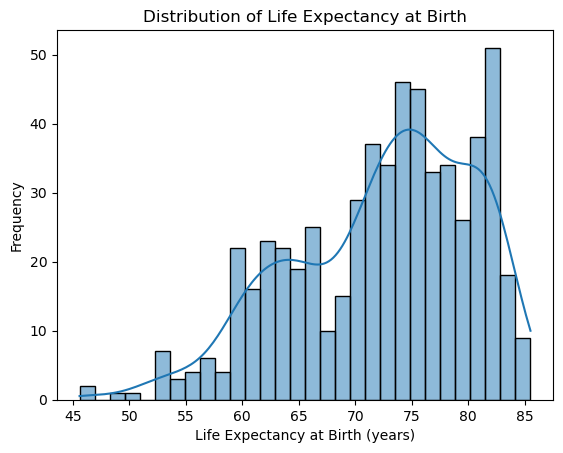

In [42]:
# check hci and life expectancy correlation
# then check one that does not really relate and try to explain why not
# Distribution of life expectancy at birth
dataset['life_expectancy_at_birth'] = pd.to_numeric(dataset['life_expectancy_at_birth'], errors='coerce')
dataset['log_life_expectancy_at_birth'] = np.log(dataset['life_expectancy_at_birth'].clip(lower=0) + 1)
dataset['sqrt_life_expectancy_at_birth'] = np.sqrt(dataset['life_expectancy_at_birth'])

# Min max scaling
min_life_exp = dataset['life_expectancy_at_birth'].min()
max_life_exp = dataset['life_expectancy_at_birth'].max()
dataset['scaled_life_expectancy_at_birth'] = (dataset['life_expectancy_at_birth'] - min_life_exp) / (max_life_exp - min_life_exp)

# Standard scaling
mean_life_exp = dataset['life_expectancy_at_birth'].mean()
std_life_exp = dataset['life_expectancy_at_birth'].std()
dataset['standardized_life_expectancy_at_birth'] = (dataset['life_expectancy_at_birth'] - mean_life_exp) / std_life_exp

sns.histplot(data=dataset, x='life_expectancy_at_birth', bins=30, kde=True)
plt.title('Distribution of Life Expectancy at Birth')
plt.xlabel('Life Expectancy at Birth (years)')
plt.ylabel('Frequency')
plt.show()

# Data is not normally distributed, even after trying various transformations

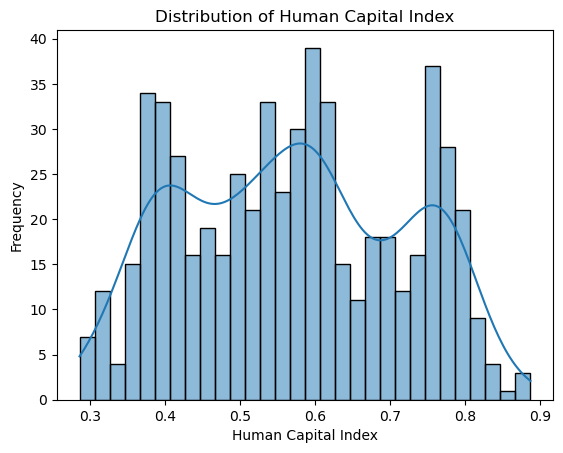

In [ ]:
#Lof transformation to reduce skewness
dataset['human_capital_index'] = pd.to_numeric(dataset['human_capital_index'], errors='coerce')
dataset['log_human_capital_index'] = np.log(dataset['human_capital_index'].clip(lower=0) + 1)
dataset['sqrt_human_capital_index'] = np.sqrt(dataset['human_capital_index'])

# Min max scaling
min_hci = dataset['human_capital_index'].min()
max_hci = dataset['human_capital_index'].max()
dataset['scaled_human_capital_index'] = (dataset['human_capital_index'] - min_hci) / (max_hci - min_hci)

# Standard scaling
mean_hci = dataset['human_capital_index'].mean()
std_hci = dataset['human_capital_index'].std()
dataset['standardized_human_capital_index'] = (dataset['human_capital_index'] - mean_hci) / std_hci

sns.histplot(data=dataset, x='human_capital_index', bins=30, kde=True)
plt.title('Distribution of Human Capital Index')
plt.xlabel('Human Capital Index')
plt.ylabel('Frequency')
plt.show()

# Data is not normally distributed, even after trying various transformations


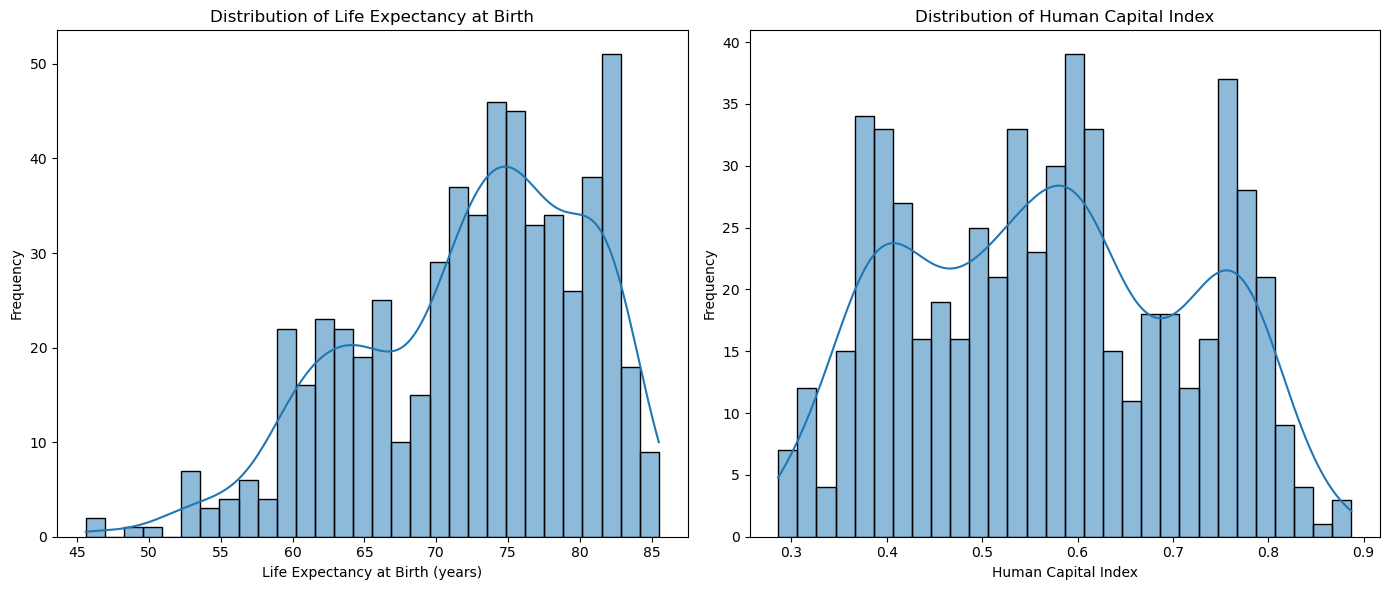

In [43]:
# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Adjust figsize as needed

# Plot the first histogram
sns.histplot(data=dataset, x='life_expectancy_at_birth', bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Life Expectancy at Birth')
axes[0].set_xlabel('Life Expectancy at Birth (years)')
axes[0].set_ylabel('Frequency')

# Plot the second histogram
sns.histplot(data=dataset, x='human_capital_index', bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Human Capital Index')
axes[1].set_xlabel('Human Capital Index')
axes[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


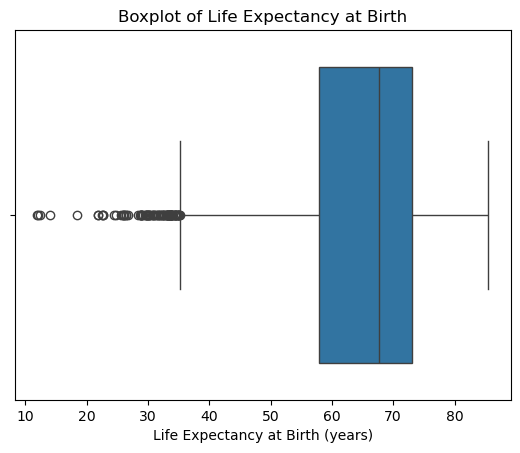

In [21]:
# Check for outliers
sns.boxplot(x=dataset['life_expectancy_at_birth'])
plt.title('Boxplot of Life Expectancy at Birth')
plt.xlabel('Life Expectancy at Birth (years)')
plt.show()

# there are outliers but they seem valid (countries with very low life expectancy due to various factors)

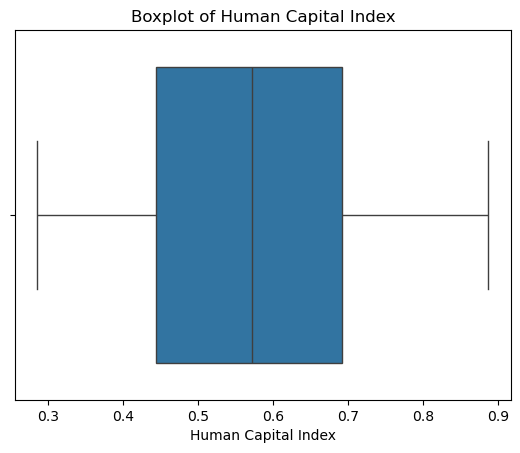

In [ ]:
# Check for outliers
sns.boxplot(x=dataset['human_capital_index'])
plt.title('Boxplot of Human Capital Index')
plt.xlabel('Human Capital Index')
plt.show()

# no outliers detected

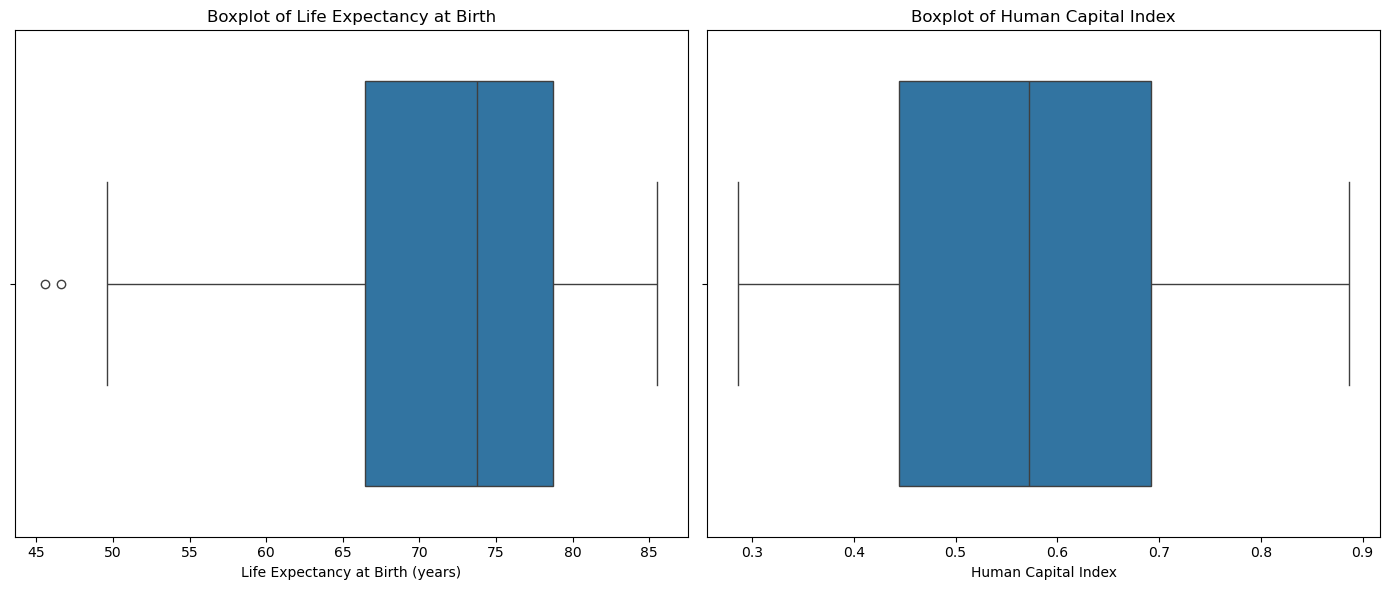

In [44]:
# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Adjust figsize as needed

# Boxplot for Life Expectancy at Birth
sns.boxplot(x=dataset['life_expectancy_at_birth'], ax=axes[0])
axes[0].set_title('Boxplot of Life Expectancy at Birth')
axes[0].set_xlabel('Life Expectancy at Birth (years)')

# Boxplot for Human Capital Index
sns.boxplot(x=dataset['human_capital_index'], ax=axes[1])
axes[1].set_title('Boxplot of Human Capital Index')
axes[1].set_xlabel('Human Capital Index')

# Adjust layout
plt.tight_layout()
plt.show()

In [23]:
pg.normality(dataset["life_expectancy_at_birth"])

/Users/megankelly/anaconda/anaconda3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12337.
  res = hypotest_fun_out(*samples, **kwds)


,W,pval,normal
life_expectancy_at_birth,0.950981,4.933214e-53,False


In [ ]:
pg.normality(dataset["human_capital_index"])

# Tests confirm that the data is not normally distributed

,W,pval,normal
human_capital_index,0.966251,2.770907e-10,False


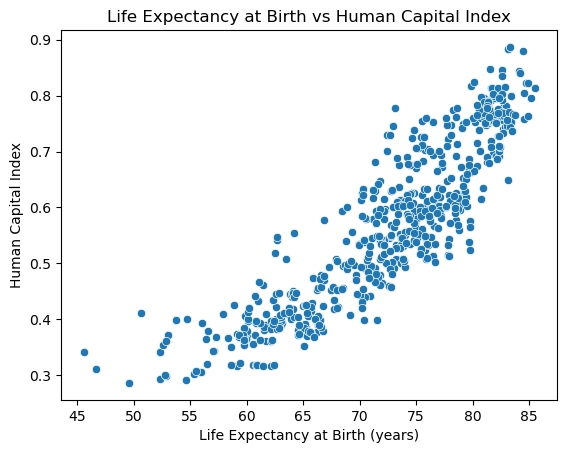

In [25]:
# Create visualization of correlation
sns.scatterplot(data=dataset, x='life_expectancy_at_birth', y='human_capital_index')
plt.title('Life Expectancy at Birth vs Human Capital Index')
plt.xlabel('Life Expectancy at Birth (years)')
plt.ylabel('Human Capital Index')
plt.show()

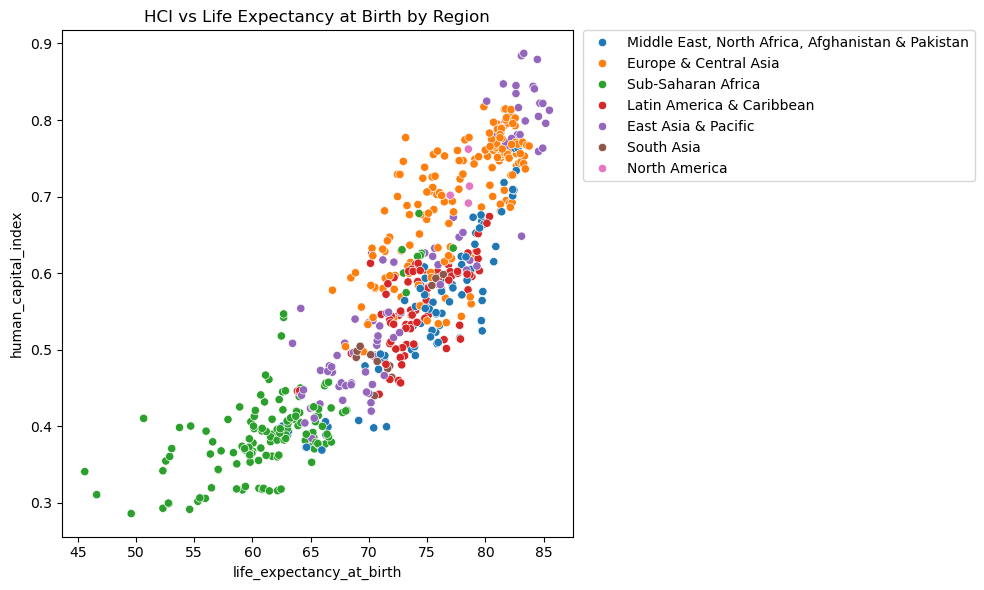

In [45]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    data=dataset,
    y="human_capital_index",
    x="life_expectancy_at_birth",
    hue="Region"
)

# Legend outside right
ax.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0
)

plt.title("HCI vs Life Expectancy at Birth by Region")
plt.tight_layout()
plt.show()


In [37]:
# Select rows for the two regions and only the desired columns
dataset2 = dataset.loc[
	dataset["Region"].isin(["East Asia & Pacific", "Europe & Central Asia"]),
	["human_capital_index", "Region", "life_expectancy_at_birth"]
].copy()

In [38]:
group1_hci = dataset2.loc[dataset2["Region"] == "East Asia & Pacific", "human_capital_index"]
group2_hci = dataset2.loc[dataset2["Region"] == "Europe & Central Asia", "human_capital_index"]

group1_life = dataset2.loc[dataset2["Region"] == "East Asia & Pacific", "life_expectancy_at_birth"]
group2_life = dataset2.loc[dataset2["Region"] == "Europe & Central Asia", "life_expectancy_at_birth"]





In [ ]:
# Run MWU test to see if the distributions of the Regions significantly different
pg.mwu(group1_hci, group2_hci)

,U-val,alternative,p-val,RBC,CLES
MWU,5023.5,two-sided,0.000004,-0.34747,0.326265


In [40]:
pg.mwu(group1_life, group2_life)

,U-val,alternative,p-val,RBC,CLES
MWU,5636.0,two-sided,0.000386,-0.267909,0.366045


In [ ]:
# Calculate Spearman correlation within each region
def spearman_by_group(group):
    return pg.corr(group["life_expectancy_at_birth"], group["human_capital_index"], method="spearman")

results = dataset2.groupby("Region").apply(spearman_by_group)
print(results)

                                  n         r         CI95%         p-val  \
Region                                                                      
East Asia & Pacific   spearman   89  0.893424  [0.84, 0.93]  5.522349e-32   
Europe & Central Asia spearman  173  0.717542  [0.64, 0.78]  1.169002e-28   

                                power  
Region                                 
East Asia & Pacific   spearman    1.0  
Europe & Central Asia spearman    1.0  


/var/folders/x_/zccbsk657rb51hx1tc0t1ss80000gn/T/ipykernel_84271/2915899625.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = dataset2.groupby("Region").apply(spearman_by_group)


In both East Asia & Pacific and Europe & Central Asia, higher human capital index values are strongly associated with higher life expectancy at birth. This association is slightly stronger in East Asia & Pacific than in Europe & Central Asia. The correlations are highly statistically significant and robust.

In [ ]:
# Use Spearman, because data is not normally distributed (tried everything)
# no outliers identified




NameError: name 'spearmanr' is not defined